In [2]:
# Adding the path of the agent's class as a system path
import sys
sys.path.append('../src')
import EVs_naive_policy as EVs_naive_policy


# Importing required libraries
import subprocess
import argparse
import math
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from itertools import chain
from statistics import mean
import random
from functools import reduce
from scipy import signal, spatial
from scipy.stats import norm
import  seaborn as sns

# Input EVs Data

In [3]:
p_max = 7 # Rated charging power of each EV (in kW)
congestion_limit = 56 # Congestion limit (in kW)
daily_decision_instants  = 1440

In [4]:
# Reading EVs data (arrival times, departure times, initial SoC, final SoC, chrage required)
evs_df = pd.read_csv(r'../data/EV/evs_data.csv' , index_col=False)
evs_df.head()

t_arrive  t_depart    soc_i  soc_f  chrg_req
0       540      1059  0.30333    0.8       234
1       600      1065  0.30333    0.8       234
2       383       745  0.71024    0.8        43
3       684      1032  0.30333    0.8       234
4       826      1349  0.30333    0.8       234

# Input Solar Data

In [5]:
new_index = {} # Dictitonary to index dataframe
pv_data = {} # Dictionary to hold PV data
year_last = int('2020')+1
y1 = '01/01/'+'2020'+' 00:00' # Starting date and time of the dataset
y2 = '31/12/'+'2020'+' 23:55' # Enging date and time of the dataset
new_index.update({'2020': pd.date_range(y1,y2,freq='5T')}) # Create an index for the dataset

#Location of the PV data file
data_file = pd.read_csv(r'../data/Solar/2020.csv',low_memory=False)
data_file.columns = data_file.iloc[1] # Change the columns name

# Extract important data for application, ie GHI :Gloal horizontal Iradiance
data_bis = pd.DataFrame(data=data_file.iloc[2:,[7,10]])
data_bis.index=new_index['2020']
for elmm in data_bis.columns:
    data_bis[elmm] = np.array(data_bis[elmm], dtype=float)

# Dictionary of PV data
pv_data.update({'2020':data_bis })

In [6]:
# Numpy array to store PV data used in Simulation studies
solar_data = np.zeros([60,daily_decision_instants])
day = 0 # Starting day index

# Storing each day's solar data in the solar_data array
for i in range(92,92+60):
    day_data_df = signal.resample(pv_data['2020']['GHI'][i*288:(i+1)*288].values,daily_decision_instants)
    solar_data[day] = day_data_df * 0.06
    day = day+1

# Setting all negative values as zero
solar_data[solar_data<0] = 0

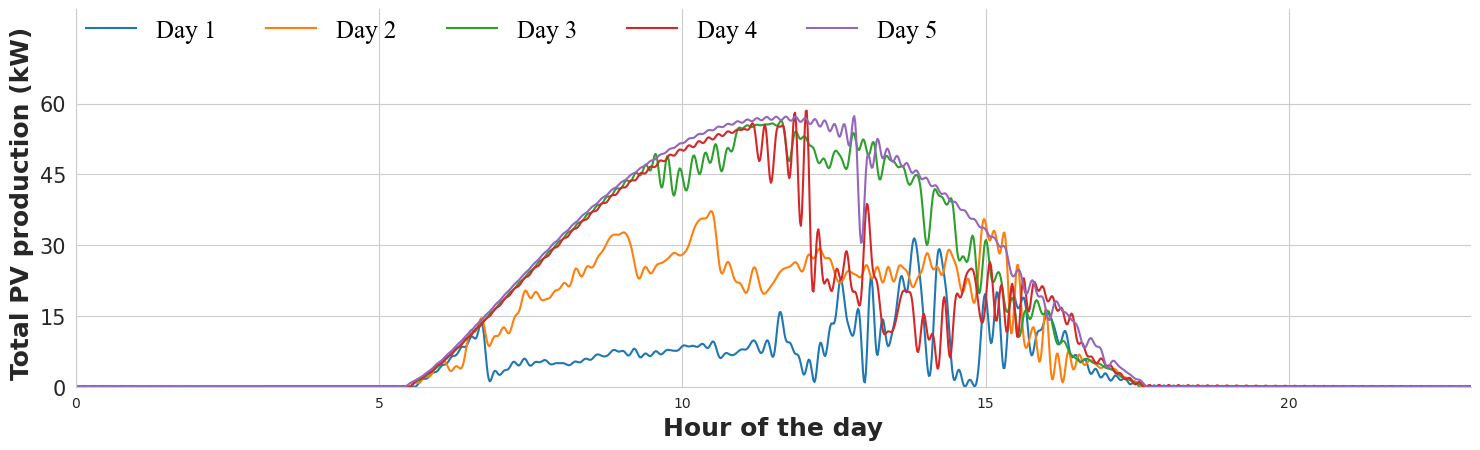

In [7]:
# Plotting first 5 days' PV data
# Plot formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
for day in range(0,5):
    plt.plot(np.linspace(0,23,daily_decision_instants),solar_data[day], label = 'Day ' + str(day+1))

# Plot formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Total PV production (kW) ", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,80)
plt.yticks([0, 15, 30, 45, 60], fontsize = 15);
plt.grid(visible=None)
plt.legend(fontsize=18, loc='upper left', ncol = 5, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

# Naive charging policy of each EV agent

In [8]:
selected_solar_profile = solar_data[6]

In [9]:
# Create arrays of ones of length len(selected_solar_profile) (decision instants) for each EV ((len(evs_df) EVs)
ev_charging_slots = np.zeros((len(evs_df),len(selected_solar_profile)))
ev_charging_policy = np.zeros((len(evs_df),len(selected_solar_profile)))

# Making the EVs_naive_policy object to calculate the naive policy of all agents
ev_charging_slots, ev_charging_policy = EVs_naive_policy.EVs_naive_policy(evs_df,selected_solar_profile).calculate_naive_policy()

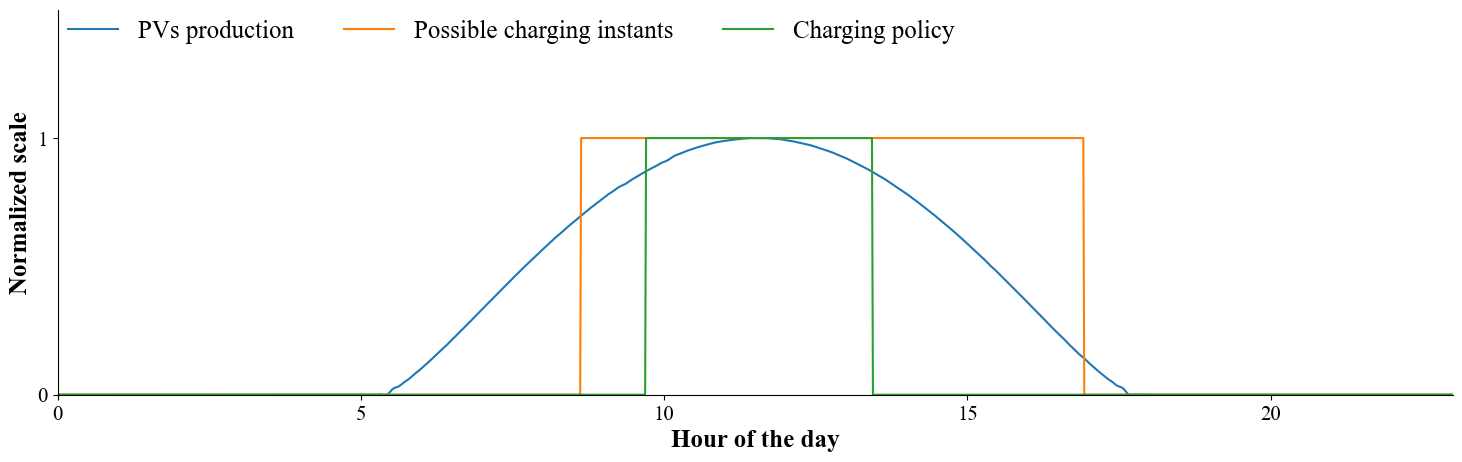

In [10]:
# Plotting selected solar profile for naive policy and possible charging slots and naive policy of the first EV agent
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting results
plt.plot(np.linspace(0,23,daily_decision_instants),selected_solar_profile / np.max(selected_solar_profile))
plt.plot(np.linspace(0,23,daily_decision_instants),ev_charging_slots[0])
plt.plot(np.linspace(0,23,daily_decision_instants),ev_charging_policy[0])

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Normalized scale", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.5)
plt.yticks([0, 1.0], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Possible charging instants', 'Charging policy'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

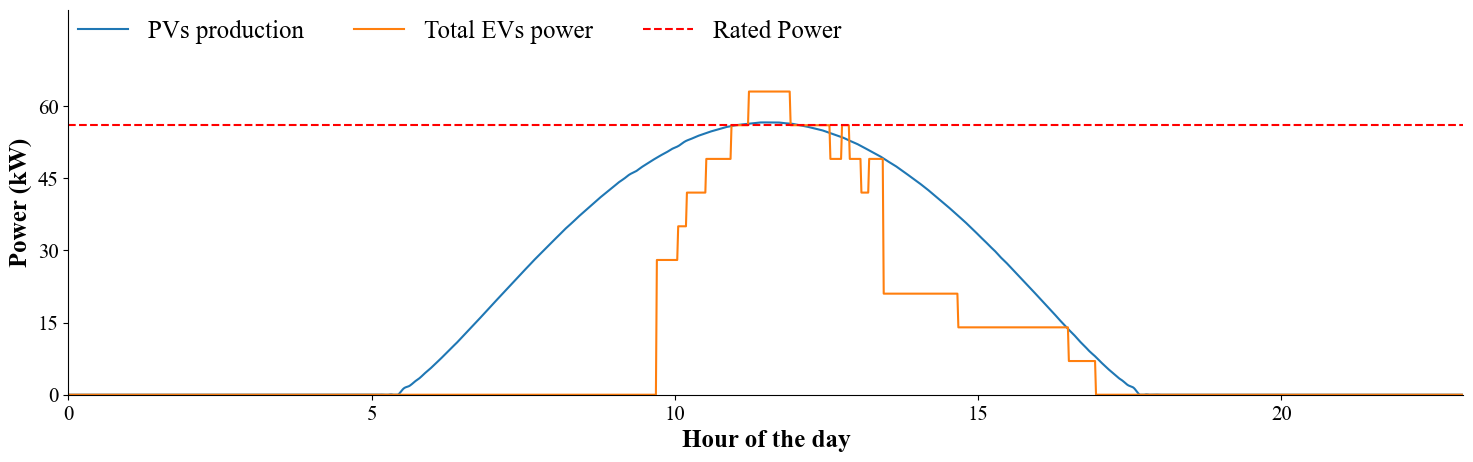

In [11]:
# Plotting cummulative charging powers of all EVs
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,daily_decision_instants),selected_solar_profile)
plt.plot(np.linspace(0,23,daily_decision_instants),np.sum(ev_charging_policy,axis=0)*p_max)
plt.axhline(y=congestion_limit, color='r', linestyle='--')


# Plot formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Power (kW)", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,80)
plt.yticks([0, 15, 30,45,60], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Total EVs power', 'Rated Power'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)